In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# import acceleromter data
data = np.genfromtxt(r'data/20steps.txt',delimiter=',',skip_header=25)

In [17]:
sample_rate = 20/1000 # rate in seconds
K = int(0.5/sample_rate) # min distance between peaks threshold [samples]

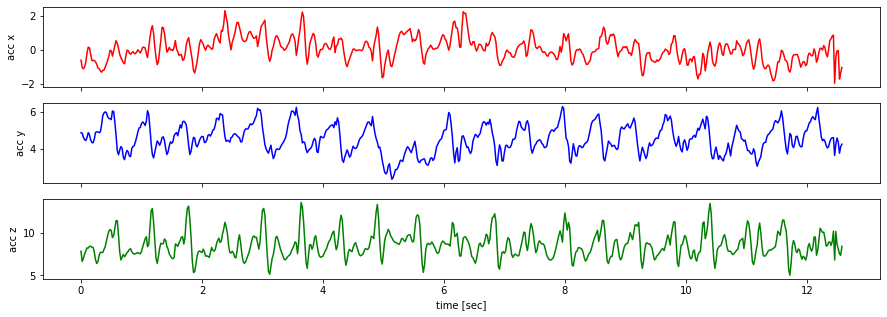

In [11]:
# plot accelerations data in each axes
fig, axs = plt.subplots(nrows=3, ncols=1,sharex=True, figsize=(15,5))

axs[0].plot(np.arange(len(data))*sample_rate,data[:,0],'-r')
axs[0].set_ylabel('acc x')

axs[1].plot(np.arange(len(data))*sample_rate,data[:,1],'-b')
axs[1].set_ylabel('acc y')

axs[2].plot(np.arange(len(data))*sample_rate,data[:,2],'-g')
axs[2].set_ylabel('acc z')

axs[2].set_xlabel('time [sec]')


plt.show()

In [12]:
# compute combined acceleromter magnitude
acc_magnitude = data[:,0]**2 + data[:,1]**2 + data[:,2]**2

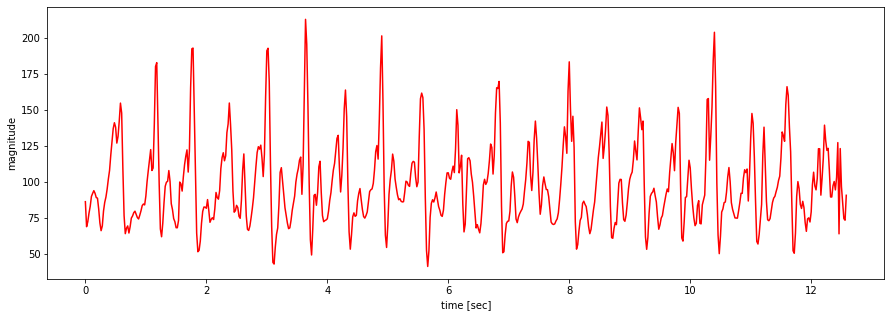

In [13]:
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.ylabel('magnitude')
plt.xlabel('time [sec]')
plt.show()

# Peak Detection

In [23]:
def peak_detector(data, K):
    
    peaks =[]

    for i, datum in enumerate(data):
        if i > 0:
            if i-K < 0 :
            
                if datum >= max(data[:i]) and datum >=max(data[i+1:i+K+1]):
                    peaks.append(i)
                    time_from_last_peak = 0 

            elif i+K > len(data) :

                if datum >= max(data[i-K:i]) and datum >=max(data[i+1:]):
                    peaks.append(i)
                    time_from_last_peak = 0 
            else :

                if datum >= max(data[i-K:i]) and datum >=max(data[i+1:i+K+1]):
                        peaks.append(i)
                        time_from_last_peak = 0 



    return np.asarray(peaks)

In [25]:
# peak detection
peaks = peak_detector(acc_magnitude,K)

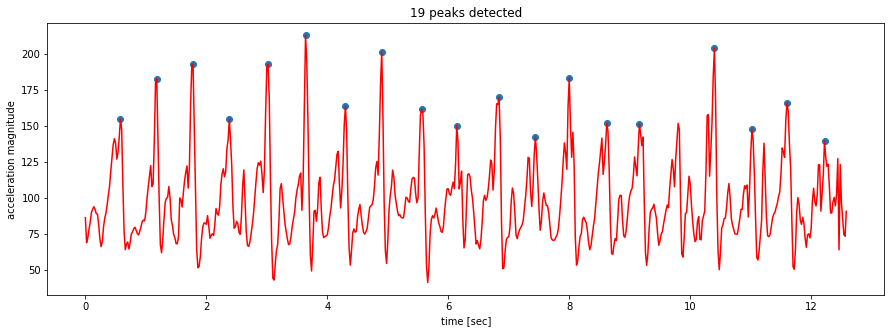

In [27]:
# plot result
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.scatter(peaks*sample_rate,acc_magnitude[peaks])
plt.ylabel('acceleration magnitude')
plt.xlabel('time [sec]')
plt.title(str(len(peaks)) + ' peaks detected')
plt.show()